<a href="https://colab.research.google.com/github/Agtna/Visi-Komputer-2025-/blob/main/Jobsheet3_Teknik_Regresi_Gambar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Praktikum D1 – Regresi dari Citra Sintetis (Prediksi Radius Lingkaran)

###1)Setup & Generator Dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras import layers, models

# Generator 1 sample
def make_sample(img_size=64, min_r=5, max_r=20):
    r = np.random.randint(min_r, max_r + 1) # radius acak
    img = np.zeros((img_size, img_size), dtype=np.uint8)
    cx = np.random.randint(r, img_size - r) # center-x
    cy = np.random.randint(r, img_size - r) # center-y
    cv2.circle(img, (cx, cy), r, (255,), -1) # lingkaran putih terisi
    img = (img / 255.0).astype(np.float32)
    # 3-channel biar kompatibel CNN
    img3 = np.stack([img, img, img], axis=-1)
    return img3, float(r), (cx, cy)

###2)“Tebak Apa?” — Tampilkan Contoh Gambar TANPA Label

Tugas kecil: Lihat gambar-gambar berikut. Kira-kira variabel kontinu apa yang ingin kita prediksi?

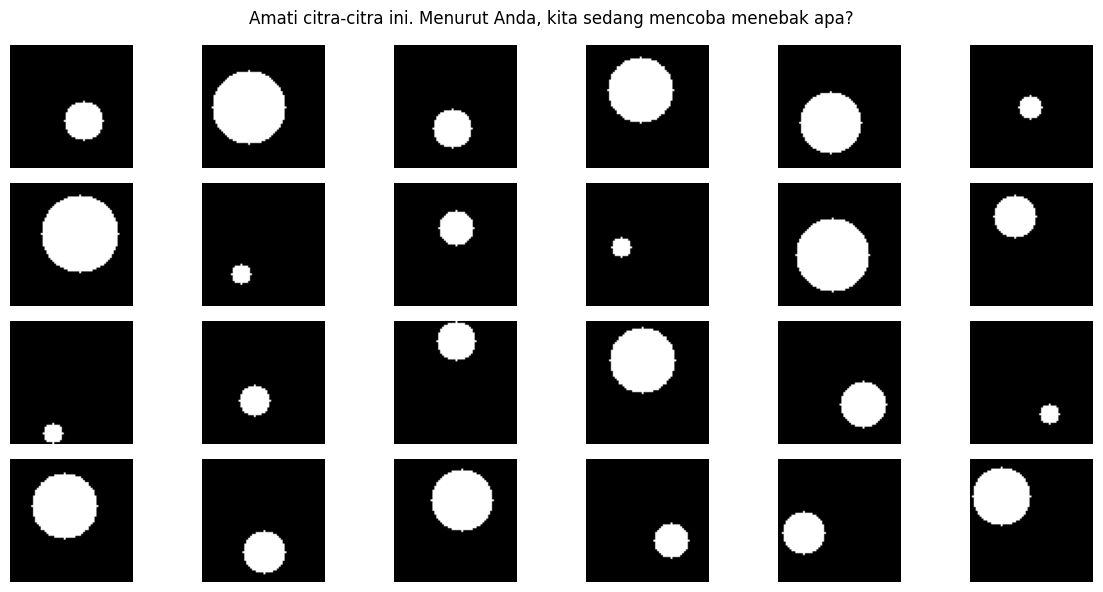

In [ ]:
# Buat 24 contoh untuk visualisasi
N_show = 24
samples = [make_sample() for _ in range(N_show)]
imgs = [s[0] for s in samples]
rads = [s[1] for s in samples]
centers = [s[2] for s in samples]
# Grid gambar tanpa label:
cols = 6
rows = N_show // cols
plt.figure(figsize=(12, 6))
for i in range(N_show):
    plt.subplot(rows, cols, i+1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.suptitle("Amati citra-citra ini. Menurut Anda, kita sedang mencoba menebak apa?")
plt.tight_layout()
plt.show()

Variabel kontinu yang diprediksi adalah radius(rads).

Diskusi cepat (di kelas):
1. Apakah yang berubah dari gambar ke gambar?
**jawaban :** ukuran lingkaran(besar-kecilnya), posisi pusat lingkaran yang berbeda - beda.

2. Apakah ukuran lingkaran berkaitan dengan sesuatu yang bisa “diukur” sebagai angka?
**jawaban:** iyaa, nilai radius yang disimpan di var rads
3. Apakah posisi pusat juga bisa jadi target?
**jawaban :** bisa, posisi pusat bisa dijadikan target karena merupakan nilai kontinu (koordinat x dan y).
Tetapi dalam kode dan visualisasi ini, target yang sebenarnya ingin diprediksi adalah radius lingkaran (rads), bukan posisi pusatnya.

###3)Buka Jawaban — Target yang Ingin Diprediksi

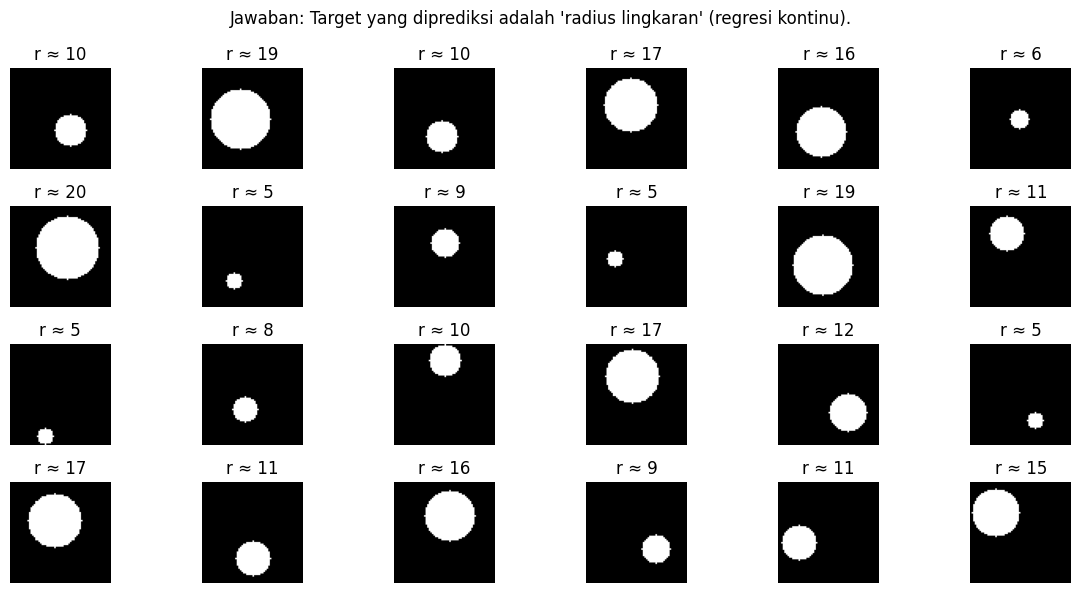

In [ ]:
# Tampilkan kembali, sekarang tampilkan radius (label) di judul tiap subplot
plt.figure(figsize=(12, 6))
for i in range(N_show):
    plt.subplot(rows, cols, i+1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.title(f"r ≈ {int(rads[i])}")
    plt.axis('off')
plt.suptitle("Jawaban: Target yang diprediksi adalah 'radius lingkaran' (regresi kontinu).")
plt.tight_layout()
plt.show()

###4)(Opsional) Latih CNN Kecil untuk Memprediksi Radius

In [ ]:
# Siapkan dataset lebih besar untuk training
N = 3000
X, y, C = zip(*[make_sample() for _ in range(N)])
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

# Model CNN sederhana
model = models.Sequential([ layers.Input((64,64,3)),
                          layers.Conv2D(32, 3, activation='relu'), layers.MaxPooling2D(),
                          layers.Conv2D(64, 3, activation='relu'), layers.MaxPooling2D(),
                          layers.Conv2D(128, 3, activation='relu'),
                          layers.GlobalAveragePooling2D(),
                          layers.Dense(64, activation='relu'),
                          layers.Dense(1) # output regresi
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(Xtr, ytr, validation_data=(Xte, yte), epochs=12, batch_size=64, verbose=0)

# Evaluasi
y_pred = model.predict(Xte).ravel()
mae = mean_absolute_error(yte, y_pred)
rmse = float(np.sqrt(np.mean((yte - y_pred)**2)))
r2 = r2_score(yte, y_pred)
print(f"MAE={mae:.3f} | RMSE={rmse:.3f} | R²={r2:.3f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
MAE=0.908 | RMSE=1.101 | R²=0.939


###Plot history & True vs Predicted:

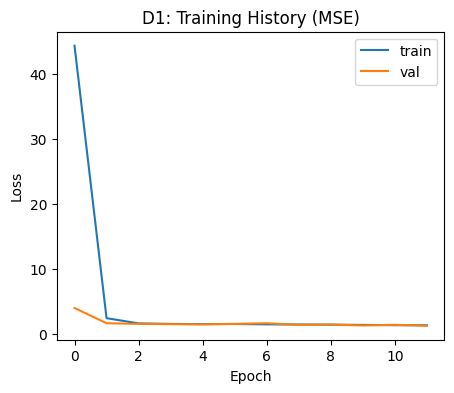

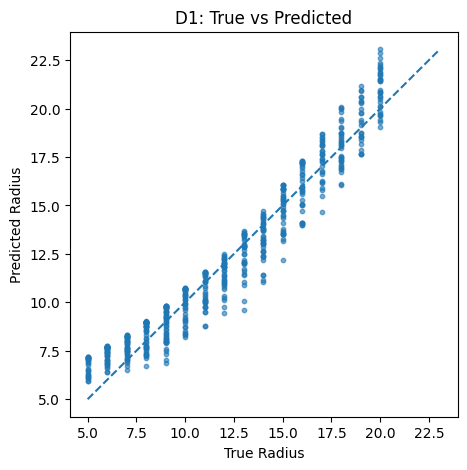

In [ ]:
# Plot loss
plt.figure(figsize=(5,4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("D1: Training History (MSE)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()

# Scatter True vs Pred
plt.figure(figsize=(5,5))
plt.scatter(yte, y_pred, s=10, alpha=0.6)
lims = [min(yte.min(), y_pred.min()), max(yte.max(), y_pred.max())]
plt.plot(lims, lims, '--')
plt.xlabel("True Radius"); plt.ylabel("Predicted Radius")
plt.title("D1: True vs Predicted")
plt.show()

###5) Tantangan Mini (Opsional untuk Mahasiswa)

Shape X: (3000, 64, 64, 3) | Shape y: (3000, 3)
Epoch 1/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 23s 453ms/step - loss: 644.1398 - mae: 22.6048 - val_loss: 149.6368 - val_mae: 8.7917
Epoch 2/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 427ms/step - loss: 127.7871 - mae: 8.0522 - val_loss: 58.7478 - val_mae: 6.2066
Epoch 3/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 413ms/step - loss: 61.6063 - mae: 6.3319 - val_loss: 52.9594 - val_mae: 5.7495
Epoch 4/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 415ms/step - loss: 54.7392 - mae: 5.7553 - val_loss: 49.5135 - val_mae: 5.4732
Epoch 5/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 22s 454ms/step - loss: 52.3247 - mae: 5.5441 - val_loss: 46.8456 - val_mae: 5.1719
Epoch 6/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 415ms/step - loss: 48.8558 - mae: 5.2216 - val_loss: 45.4695 - val_mae: 4.9921
Epoch 7/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 419ms/step - loss: 47.0222 - mae: 5.0356 - val_loss: 43.8668 - val_mae: 4.9325
Epoch 8/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 475ms/step - loss: 46.0467 - mae: 5.0076 - val_loss: 43.965

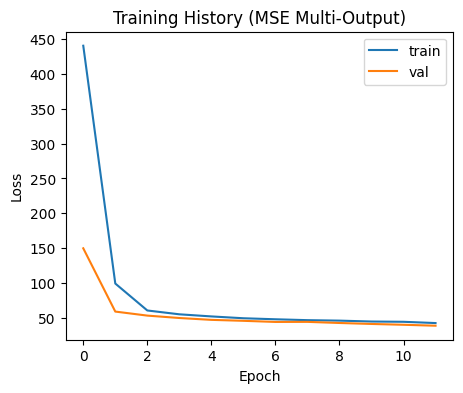

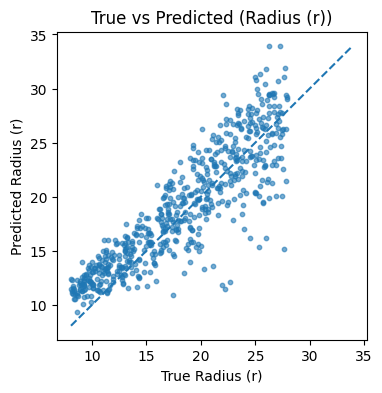

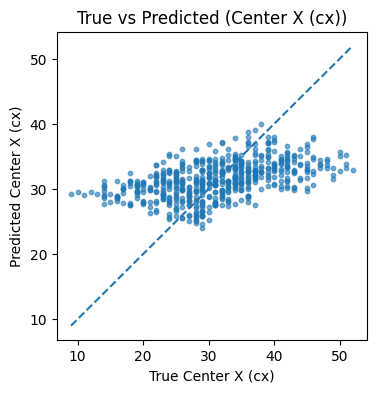

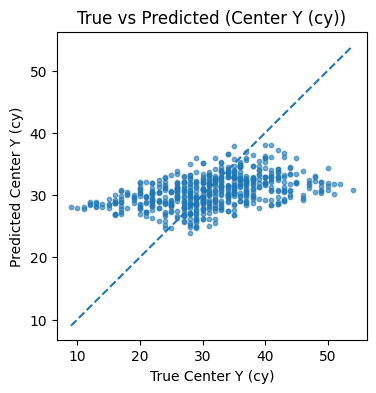

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras import models, layers

# ============================================================
# 1️⃣ Fungsi pembuat sampel data
# ============================================================
def make_sample(img_size=64):
    img = np.zeros((img_size, img_size, 3), dtype=np.uint8)

    # Pilih radius dan posisi acak (pastikan tidak keluar frame)
    r = np.random.uniform(8, 28)
    cx = np.random.randint(int(r)+1, img_size-int(r)-1)
    cy = np.random.randint(int(r)+1, img_size-int(r)-1)

    # Warna acak
    color = tuple(np.random.randint(0, 256, size=3).tolist())

    # Gambar lingkaran
    cv2.circle(img, (cx, cy), int(r), color, -1)

    # Normalisasi gambar 0–1
    img = img.astype(np.float32) / 255.0

    # Output: gambar, target (r, cx, cy), warna (hanya untuk info)
    return img, (r, cx, cy), color

# ============================================================
# 2️⃣ Siapkan dataset
# ============================================================
N = 3000
X, y, C = zip(*[make_sample() for _ in range(N)])  # (img, [r,cx,cy], color)
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

print("Shape X:", X.shape, "| Shape y:", y.shape)

# Split train/test
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

# ============================================================
# 3️⃣ Model CNN multi-output
# ============================================================
model = models.Sequential([
    layers.Input((64,64,3)),
    layers.Conv2D(32, 3, activation='relu'), layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'), layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3)   # output: [r, cx, cy]
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(Xtr, ytr, validation_data=(Xte, yte),
                    epochs=12, batch_size=64, verbose=1)

# ============================================================
# 4️⃣ Evaluasi
# ============================================================
y_pred = model.predict(Xte)

mae_r = mean_absolute_error(yte[:,0], y_pred[:,0])
mae_cx = mean_absolute_error(yte[:,1], y_pred[:,1])
mae_cy = mean_absolute_error(yte[:,2], y_pred[:,2])
mae_avg = np.mean([mae_r, mae_cx, mae_cy])

r2_r = r2_score(yte[:,0], y_pred[:,0])
r2_cx = r2_score(yte[:,1], y_pred[:,1])
r2_cy = r2_score(yte[:,2], y_pred[:,2])
r2_avg = np.mean([r2_r, r2_cx, r2_cy])

dist_error = np.mean(np.linalg.norm(y_pred - yte, axis=1))

print(f"MAE_r={mae_r:.3f}, MAE_cx={mae_cx:.3f}, MAE_cy={mae_cy:.3f}, MAE_avg={mae_avg:.3f}")
print(f"R²_r={r2_r:.3f}, R²_cx={r2_cx:.3f}, R²_cy={r2_cy:.3f}, R²_avg={r2_avg:.3f}")
print(f"Mean Euclidean Distance Error = {dist_error:.3f}")

# ============================================================
# 5️⃣ Visualisasi hasil
# ============================================================
plt.figure(figsize=(5,4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("Training History (MSE Multi-Output)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()

labels = ['Radius (r)', 'Center X (cx)', 'Center Y (cy)']
for i in range(3):
    plt.figure(figsize=(4,4))
    plt.scatter(yte[:,i], y_pred[:,i], s=10, alpha=0.6)
    lims = [min(yte[:,i].min(), y_pred[:,i].min()),
            max(yte[:,i].max(), y_pred[:,i].max())]
    plt.plot(lims, lims, '--')
    plt.xlabel(f"True {labels[i]}"); plt.ylabel(f"Predicted {labels[i]}")
    plt.title(f"True vs Predicted ({labels[i]})")
    plt.show()


##Praktikum D2 – Menebak Umur Manusia dari Foto Wajah (UTKFace)

###Langkah 2 — Mengunggah kaggle.json ke Colab

In [10]:
#Jalankan ini di awal notebook
from google.colab import files
files.upload() # pilih file kaggle.json dari komputer Anda

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"putrilevinaa","key":"eea69ab136245c765279cc40306a5968"}'}

In [11]:
import os, shutil
if os.path.exists("kaggle.json"):
      os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
      shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
      os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
      !pip -q install kaggle
      print("✅ Kaggle API siap digunakan.")
else:
      print(" .ı kaggle.json belum ditemukan. Upload terlebih dahulu.")

✅ Kaggle API siap digunakan.


###Langkah 3 — Mengunduh Dataset UTKFace dari Kaggle

In [12]:
# Unduh dataset UTKFace (sekali saja)
!kaggle datasets download -d jangedoo/utkface-new -p /content -q
!unzip -q /content/utkface-new.zip -d /content/utk
print("✅ Dataset UTKFace berhasil diekstrak.")

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
✅ Dataset UTKFace berhasil diekstrak.


###E.Langkah 4 — Menampilkan Contoh Gambar Dataset

Total gambar ditemukan: 23708


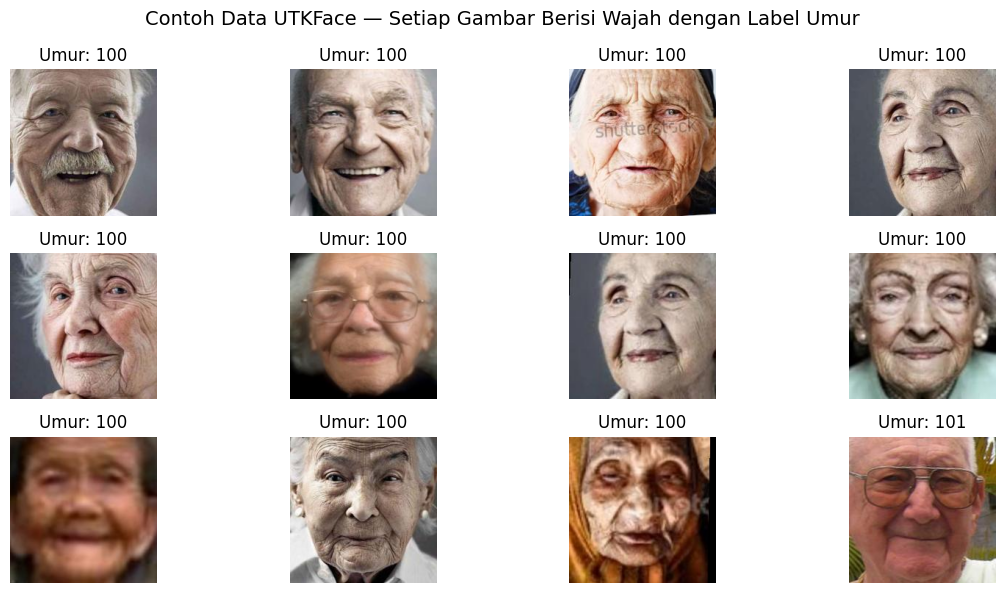

In [13]:
import matplotlib.pyplot as plt
import os, glob
from PIL import Image

# Ambil 12 gambar acak dari dataset
files = glob.glob("/content/utk/UTKFace/*.jpg")
files = sorted(files)
print(f"Total gambar ditemukan: {len(files)}")

plt.figure(figsize=(12, 6))
for i, f in enumerate(files[:12]):
   # Ambil umur dari nama file
    age = int(os.path.basename(f).split("_")[0])
    img = Image.open(f)
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Umur: {age}")
    plt.axis("off")
plt.suptitle("Contoh Data UTKFace — Setiap Gambar Berisi Wajah dengan Label Umur", fontsize=14)
plt.tight_layout()
plt.show()

###Langkah 5 — Siapkan Dataset untuk Model

In [14]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

def parse_age_from_name(fp):
    return int(os.path.basename(fp).split('_')[0])

ages = np.array([parse_age_from_name(f) for f in files], dtype=np.float32)
train_files, test_files, y_train, y_test = train_test_split(files, ages, test_size=0.2, random_state=42)

IMG_SIZE = 160
def load_img(fp, label):
    img = tf.io.read_file(fp)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    return img / 255.0, label

train_ds = tf.data.Dataset.from_tensor_slices((train_files, y_train)).map(load_img).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((test_files, y_test)).map(load_img).batch(64)

print("✅ Dataset siap dilatih.")

✅ Dataset siap dilatih.


###Langkah 6 — Membangun Model dengan Transfer Learning

In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Gunakan GPU jika tersedia
print("Hardware:", "GPU" if tf.config.list_physical_devices('GPU') else "CPU")

# Buat arsitektur model
base_model = tf.keras.applications.MobileNetV2(
            include_top=False,
            input_shape=(IMG_SIZE, IMG_SIZE, 3),
            weights='imagenet')
base_model.trainable = False # tahap awal: freeze backbone

# Tambahkan head regresi
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs * 255.0)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1)(x) # output tunggal: umur
model = tf.keras.Model(inputs, outputs)

# Kompilasi model
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),loss='mse', metrics=['mae'])

model.summary()

Hardware: GPU
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply (Multiply)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

###Langkah 7 — Melatih Model (Tahap 1 – Frozen)

Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 56s 128ms/step - loss: 339.6166 - mae: 13.5305 - val_loss: 158.8421 - val_mae: 9.6102 - learning_rate: 0.0010
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - loss: 156.2024 - mae: 9.3561 - val_loss: 149.6593 - val_mae: 9.2740 - learning_rate: 0.0010
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - loss: 145.3445 - mae: 8.9305 - val_loss: 141.2348 - val_mae: 8.8689 - learning_rate: 0.0010
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - loss: 141.2897 - mae: 8.7670 - val_loss: 136.9432 - val_mae: 8.6419 - learning_rate: 0.0010
Epoch 5/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 136.6630 - mae: 8.5976 - val_loss: 136.6707 - val_mae: 8.6681 - learning_rate: 0.0010
Epoch 6/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 134.9067 - mae: 8.5146 - val_loss: 133.9704 - val_mae: 8.5278 - learning_rate: 0.0010
Epoch 7/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 132.3684 - mae: 8.4122 - val_loss: 139.2851 - va

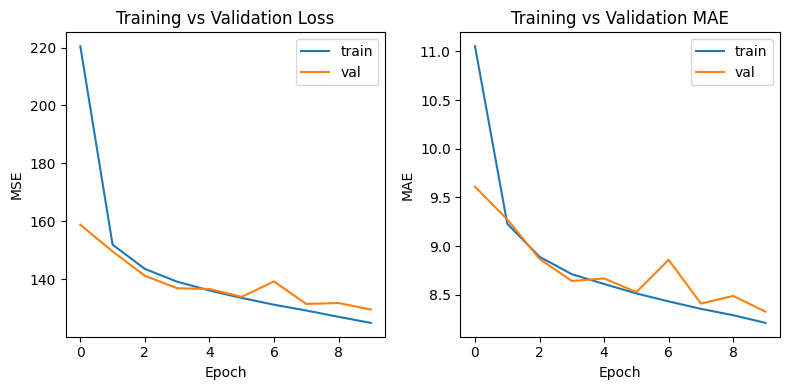

In [17]:
# Callback untuk pelatihan yang lebih stabil
cb = [
    tf.keras.callbacks.EarlyStopping(
        patience=3,
        restore_best_weights=True,
        monitor='val_loss'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        patience=2,
        factor=0.5,
        min_lr=1e-5,
        monitor='val_loss'
    )
]

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=cb,
    verbose=1
)

# Visualisasi perubahan loss dan MAE selama pelatihan:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training vs Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='val')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training vs Validation MAE')
plt.legend()

plt.tight_layout()
plt.show()


###Langkah 8 — Fine-tuning Backbone (Tahap 2)

Epoch 1/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 47s 98ms/step - loss: 193.6734 - mae: 10.2857 - val_loss: 140.1880 - val_mae: 9.0869 - learning_rate: 1.0000e-04
Epoch 2/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - loss: 78.1392 - mae: 6.6274 - val_loss: 116.0056 - val_mae: 8.1194 - learning_rate: 1.0000e-04
Epoch 3/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - loss: 51.7703 - mae: 5.4459 - val_loss: 109.5805 - val_mae: 7.7596 - learning_rate: 1.0000e-04
Epoch 4/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - loss: 37.7509 - mae: 4.6552 - val_loss: 103.1465 - val_mae: 7.4605 - learning_rate: 1.0000e-04
Epoch 5/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - loss: 29.8747 - mae: 4.1561 - val_loss: 103.2188 - val_mae: 7.4050 - learning_rate: 1.0000e-04


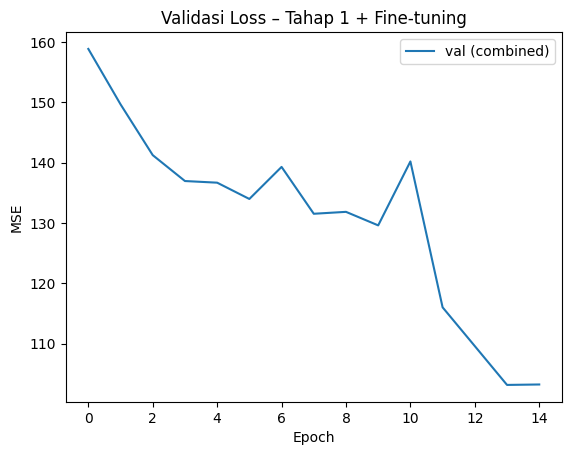

In [18]:
# Aktifkan kembali sebagian layer terakhir untuk fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False  # Beku sebagian besar layer

# Recompile dengan learning rate lebih kecil
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='mse',
    metrics=['mae']
)

history_ft = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5,
    callbacks=cb,
    verbose=1
)

# Visualisasi gabungan training dan fine-tuning:
plt.plot(
    history.history['val_loss'] + history_ft.history['val_loss'],
    label='val (combined)'
)
plt.title("Validasi Loss – Tahap 1 + Fine-tuning")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()


###Langkah 9 — Evaluasi Akhir (MAE, RMSE, R²)

MAE = 7.46 tahun
RMSE = 10.16 tahun
R2 = 0.740


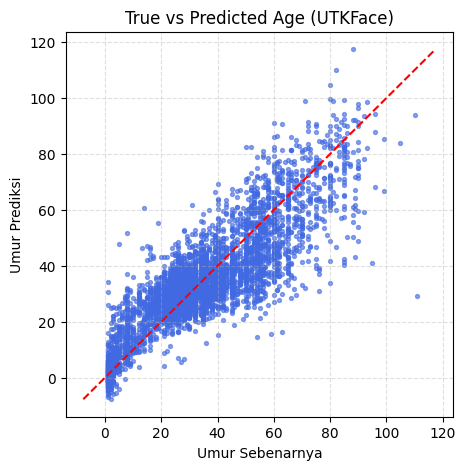

In [19]:
from math import sqrt

y_pred = np.concatenate([model.predict(batch[0], verbose=0).ravel() for
batch in test_ds])
mae = mean_absolute_error(y_test, y_pred)
rmse = sqrt(np.mean((y_test - y_pred)**2))
r2 = r2_score(y_test, y_pred)

print(f"MAE = {mae:.2f} tahun")
print(f"RMSE = {rmse:.2f} tahun")
print(f"R2 = {r2:.3f}")

# Plot “umur sebenarnya vs umur prediksi”:
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred, s=8, alpha=0.6, color='royalblue')
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')
plt.xlabel("Umur Sebenarnya")
plt.ylabel("Umur Prediksi")
plt.title("True vs Predicted Age (UTKFace)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

###Langkah 10 — Melihat Contoh Prediksi Nyata

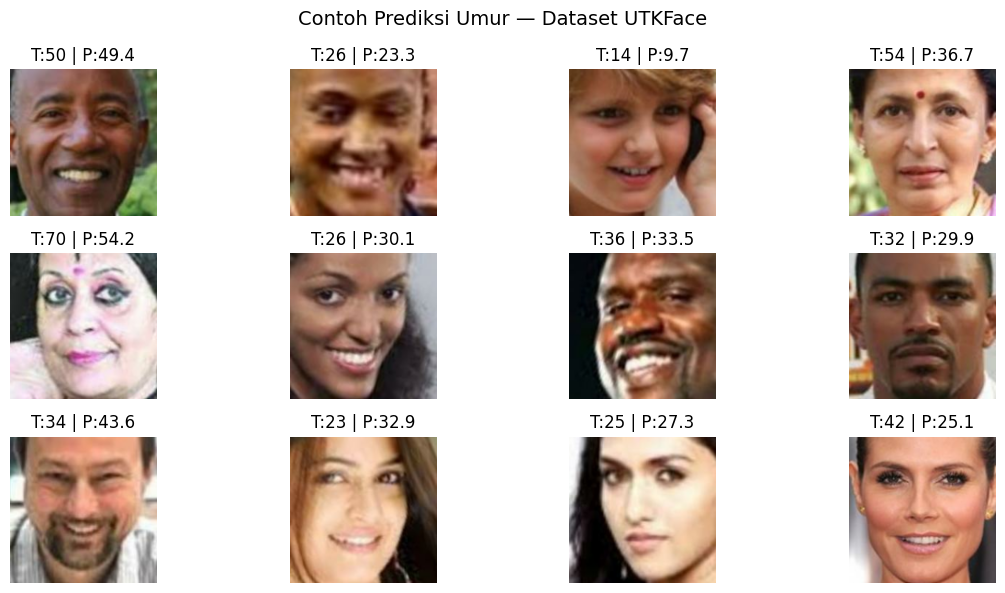

In [20]:
import random
sample_paths = random.sample(test_files, 12)

plt.figure(figsize=(12,6))
for i, path in enumerate(sample_paths):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))/255.0
    true_age = int(os.path.basename(path).split('_')[0])
    pred_age = model.predict(tf.expand_dims(img, 0), verbose=0).ravel()[0]
    plt.subplot(3,4,i+1)
    plt.imshow(img.numpy())
    plt.title(f"T:{true_age} | P:{pred_age:.1f}")
    plt.axis('off')
plt.suptitle("Contoh Prediksi Umur — Dataset UTKFace", fontsize=14)
plt.tight_layout()
plt.show()

###Tantangan Mini (Opsional)

1.Tambahkan data augmentation ekstra (kontras, brightness, zoom).
→ Bagaimana pengaruhnya pada MAE?
2.Ubah learning rate schedule atau optimizer.
→ Apakah model lebih stabil?
3.Pisahkan dataset per kelompok umur (0–10, 11–20, dst).
→ Mana kelompok dengan error terbesar?
4.Uji model Anda pada wajah sendiri (setelah resize).
→ Apakah prediksinya realistis?